# CNN을 활용한 특징 기반 모델

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, TensorDataset

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
train_dataset  = torchvision.datasets.FashionMNIST("data", 
                                                   download=True, 
                                                   transform=transforms.Compose([transforms.ToTensor()]))
test_dataset  = torchvision.datasets.FashionMNIST("data", 
                                                  download=True, 
                                                  train=False, 
                                                  transform=transforms.Compose([transforms.ToTensor()])) 

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset,  
                                          batch_size=128)

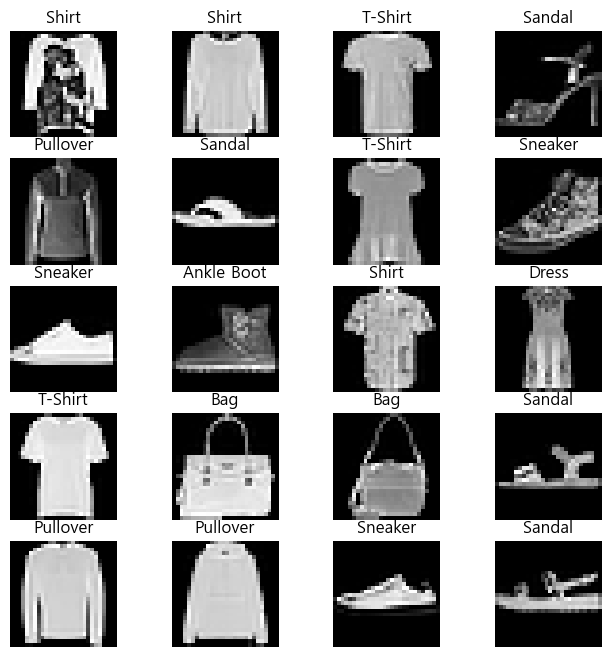

In [5]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [6]:
class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        ## 분류 계층
        self.drop = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=512)        
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x) # 128*3*3

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x)) # 512
        x = self.drop(x)
        x = F.relu(self.fc2(x)) # 256        
        x = self.fc3(x)
        
        return x

In [7]:
def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], "
                    f"Loss: {loss.item():.4f}"
                )

        train_accuracy = 100 * correct_train / total_train
        test_accuracy = evaluate_model(model, test_loader)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        scheduler.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Accuracy: {train_accuracy:.2f}%, "
            f"Test Accuracy: {test_accuracy:.2f}%"
        )

    return train_losses, train_accuracies, test_accuracies

In [8]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total

In [9]:
cnn_model = FashionCNN()
cnn_model.to(device)
train_model(cnn_model, train_loader, test_loader)

C:\Users\SW\AppData\Roaming\Python\Python313\site-packages\torch\nn\functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Batch [0], Loss: 2.3101
Epoch [1/10], Batch [100], Loss: 0.3361
Epoch [1/10], Batch [200], Loss: 0.3430
Epoch [1/10], Batch [300], Loss: 0.2907
Epoch [1/10], Batch [400], Loss: 0.3513
Epoch [1/10], Train Accuracy: 85.11%, Test Accuracy: 87.49%
Epoch [2/10], Batch [0], Loss: 0.2162
Epoch [2/10], Batch [100], Loss: 0.2148
Epoch [2/10], Batch [200], Loss: 0.2083
Epoch [2/10], Batch [300], Loss: 0.2277
Epoch [2/10], Batch [400], Loss: 0.2584
Epoch [2/10], Train Accuracy: 90.40%, Test Accuracy: 88.76%
Epoch [3/10], Batch [0], Loss: 0.1354
Epoch [3/10], Batch [100], Loss: 0.2148
Epoch [3/10], Batch [200], Loss: 0.1767
Epoch [3/10], Batch [300], Loss: 0.1787
Epoch [3/10], Batch [400], Loss: 0.1990
Epoch [3/10], Train Accuracy: 91.94%, Test Accuracy: 89.28%
Epoch [4/10], Batch [0], Loss: 0.1134
Epoch [4/10], Batch [100], Loss: 0.1537
Epoch [4/10], Batch [200], Loss: 0.1339
Epoch [4/10], Batch [300], Loss: 0.1692
Epoch [4/10], Batch [400], Loss: 0.1814
Epoch [4/10], Train Accuracy

([0.4060978471025475,
  0.261731444645538,
  0.21918100849397656,
  0.19019067063451067,
  0.16476192458796857,
  0.12631230760834364,
  0.10225883081777772,
  0.08743263484000652,
  0.07713885973694164,
  0.0682840931124048],
 [85.10666666666667,
  90.4,
  91.94,
  92.96833333333333,
  93.87166666666667,
  95.23333333333333,
  96.18666666666667,
  96.75833333333334,
  97.07833333333333,
  97.39166666666667],
 [87.49, 88.76, 89.28, 89.91, 90.72, 90.35, 90.15, 90.1, 91.13, 90.68])

In [ ]:
#5.3.1 특성 추출 기법

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
data_path = '../chap05/data/catanddog/train'
    
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

In [ ]:
samples, labels = iter(train_loader).next()
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
resnet18 = models.resnet18(pretrained=True)

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

In [ ]:
resnet18.fc = nn.Linear(512, 2)

In [ ]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

In [ ]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('../chap05/data/catanddog/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [ ]:
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
optimizer = optim.Adam(params_to_update)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

# 전이학습

In [ ]:
test_path = '../chap05/data/catanddog/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

In [ ]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

In [ ]:
plt.plot(train_loss_hist)
plt.show()

In [ ]:
def im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

In [ ]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [ ]:
# 5.4.1 특성 맵 시각화

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [ ]:
model=XAI()
model.to(device)
model.eval()

In [ ]:
class LayerActivations:
    features=[]
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
   
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
 
    def remove(self): 
        self.hook.remove()

In [ ]:
img=cv2.imread("../chap05/data/cat.jpg")   
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [ ]:
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()

In [ ]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

In [ ]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
plt.show()